In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.examples.tutorials.mnist import input_data

import tensorflow as tf
import numpy as np
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt

TRAIN_DIR = 'mnist/input_data'
POS = 1
NEG = 7

%matplotlib inline

# MNIST Reading #

We read only two classes of digits, defined by the `POS` and `NEG` variables above.

In [3]:
# Import MNIST data
mnist = input_data.read_data_sets(TRAIN_DIR, one_hot=True, validation_size=0)

Extracting mnist/input_data/train-images-idx3-ubyte.gz
Extracting mnist/input_data/train-labels-idx1-ubyte.gz
Extracting mnist/input_data/t10k-images-idx3-ubyte.gz
Extracting mnist/input_data/t10k-labels-idx1-ubyte.gz


(13007, 784) (2163, 784)


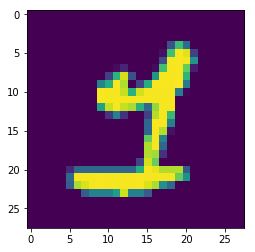

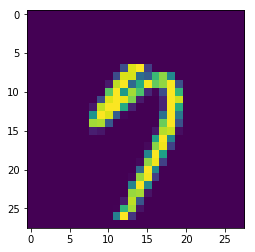

In [4]:
# Get only two digits from MNIST
def get_binary_mnist(subset, pos_label=POS, neg_label=NEG):
    X = []
    Y = []
    for i in range(subset.num_examples):
        x, y = subset.next_batch(1)
        if y.flatten()[pos_label] == 1:
            X.append(x.flatten())
            Y.append([1])
        elif y.flatten()[neg_label] == 1:
            X.append(x.flatten())
            Y.append([0])
    return np.asarray(X), np.asarray(Y)

X_train, Y_train = get_binary_mnist(mnist.train)
X_test, Y_test = get_binary_mnist(mnist.test)

print(X_train.shape, X_test.shape)

# Plot positive and negative example:
plt.imshow(X_train[np.argwhere(Y_train == 1)[0, 0]].reshape((28, 28)), interpolation="nearest", cmap="viridis")
plt.figure()
plt.imshow(X_train[np.argwhere(Y_train == 0)[0, 0]].reshape((28, 28)), interpolation="nearest", cmap="viridis")

# Logistic Regression with Numpy #

Symbols:

- $X \in \mathbb{R}^{N \times M}$ is the feature matrix, one observation per row, $N$ observations, and $M = 28 \times 28$ features per observation.
- $\hat{\mathbf{y}} \in \{0, 1\}^{N}$ are the ground-truth labels.
- $\mathbf{y} \in \mathbb{R}^N$ are the predictions of the models.
- $\mathbf{w} \in \mathbb{R}^M$ are the set of weights to learn.
- $b$ is the bias to learn.
- $\eta$ is the learning rate.

To simplify the derivatives, we will assume that the bias $b$ will always be 0 (i.e., we will not learn it).

Model:

$$\sigma(x) = \frac{1}{1 + e^{-x}}$$

$$\mathbf{y} = \sigma(X \mathbf{w} + b)$$

Loss function (binary crossentropy):

$$L = -\frac{1}{N} ( \hat{\mathbf{y}}^T \log(\mathbf{y}) + (1 - \hat{\mathbf{y}})^T \log(1 - \mathbf{y}) )$$

Partial derivate of the loss wrt weights:

$$\frac{\partial L}{\partial \mathbf{w}} = \sigma(X \mathbf{w} + b)^T(1 - \sigma(X \mathbf{w} + b)) X^T  \frac{\mathbf{y} - \hat{\mathbf{y}}}{(\mathbf{y} - 1)^T \mathbf{y}}$$

Stochastic Gradient Descent:

$$\mathbf{w}_{i+1} = \mathbf{w}_i - \eta\frac{\partial L}{\partial \mathbf{w}_i}$$

In [5]:
def affine(X, W, b):
    return np.dot(X, W) + b

def sigmoid(X):
    return 1 / (1 + np.exp(-X))

def model(X, W, b):
    return sigmoid(affine(X, W, b))

def d_sigmoid(X):
    return np.dot(sigmoid(X).T, (1- sigmoid(X)))

def d_loss(Y, Y_, X, W, b):
    ds = d_sigmoid(affine(X, W, b))
    return np.dot(X.T * ds, (Y_ - Y) / np.dot(np.transpose(Y - 1), Y))

def sgd(W, dW, lr):
    return W - lr * dW

Test Accuracy: 0.999691119066


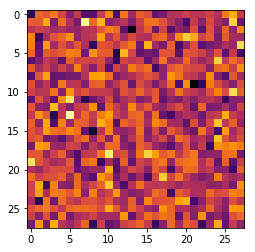

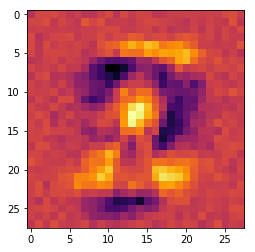

In [6]:
n_batch = 100
lr = 0.1
N_train = X_train.shape[0]
M = X_train.shape[1]

# Initialize the weights using Gaussian noise
W = np.random.normal(scale=0.1, size=(M, 1))
b = 0

plt.imshow(W.reshape((28, 28)), interpolation="nearest", cmap="inferno")
for i in range(N_train // n_batch):
    batch_X, batch_Y = X_train[i * n_batch:i * n_batch + n_batch], \
        Y_train[i * n_batch:i * n_batch + n_batch]
    Y = model(batch_X, W, b)
    
    dW = d_loss(Y, batch_Y, batch_X, W, b)
    W = sgd(W, dW, lr)
    
N_test = X_test.shape[0]
acc = []
for i in range(N_test // n_batch):
    batch_X, batch_Y = X_train[i * n_batch:i * n_batch + n_batch], \
        Y_train[i * n_batch:i * n_batch + n_batch]
    Y = model(batch_X, W, b)
    acc.append(roc_auc_score(batch_Y, Y))
    
print("Test Accuracy: {}".format(np.mean(acc)))
    
plt.figure()
plt.imshow(W.reshape((28, 28)), interpolation="nearest", cmap="inferno")

# Logistic Regression with TensorFlow #

Essentially the same model as before, but the code gets simplified thanks to `tensorflow`.

Note that we are learning $b$ in this case.

In [9]:
X = tf.placeholder(tf.float32, shape=[None, 28 * 28])
W = tf.Variable(tf.random_normal([28 * 28, 1], stddev=0.1))
b = tf.Variable(tf.zeros([1]))
Y = 1 / (1 + tf.exp(-tf.matmul(X, W) + b))

Y_ = tf.placeholder(tf.float32, [None, 1])

cross_entropy = - tf.reduce_mean(Y_ * tf.log(Y) + (1 - Y_) * tf.log(1 - Y))

train_step = tf.train.GradientDescentOptimizer(0.1).minimize(cross_entropy)

Test Accuracy: 0.998791545964


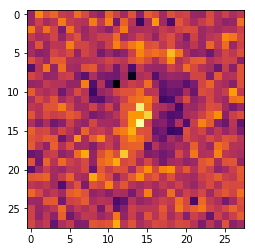

In [10]:
n_batch = 100
N_train = X_train.shape[0]

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
for i in range(N_train // n_batch):
    batch_X, batch_Y = X_train[i * n_batch:i * n_batch + n_batch], \
        Y_train[i * n_batch:i * n_batch + n_batch]
    sess.run(train_step, feed_dict={X: batch_X, Y_: batch_Y})
    
Y_pred = sess.run(Y, feed_dict={X: X_test, Y_: Y_test})
print("Test Accuracy: {}".format(roc_auc_score(Y_test, Y_pred)))

plt.imshow(W.eval().reshape((28, 28)), interpolation="nearest", cmap="inferno")

# MLP with TensorFlow #

Using `tensorflow` it becomes really simple to extend our logisitic regression example to a multilayer perceptron (MLP).

An MLP is essentially an extension of a logistic regression model with one or more hidden layers. In our code we will use a single hidden layer, using also the sigmoid activation $\sigma$.

In this case, we have:

- $W_1 \in \mathbb{R}^{M \times H}$ is the set of weights in the hidden layer, where $H$ is the number of hidden units in the hidden layer.
- $\mathbf{b}_1 \in \mathbb{R}^{H}$ is the set of biases for the hidden layer.
- $\mathbf{h} \in \mathbb{R}^{H}$ is the output of the hidden layer.
- $\mathbf{w}_2 \in \mathbb{R}^M$ are the set of weights for the output layer.
- $b_2$ is the bias for the output layer

MLP model:

$$\sigma(x) = \frac{1}{1 + e^{-x}}$$

$$\mathbf{h} = \sigma(X W_1 + \mathbf{b}_1)$$

$$\mathbf{y} = \sigma(\mathbf{h} \mathbf{w}_2 + b_2)$$

In [25]:
H = 128
M = 28 * 28
lr = 0.1
X = tf.placeholder(tf.float32, shape=[None, M])
W1 = tf.Variable(tf.random_normal([M, H], stddev=0.1))
b1 = tf.Variable(tf.zeros([H]))
W2 = tf.Variable(tf.random_normal([H, 1], stddev=0.1))
b2 = tf.Variable(tf.zeros([1]))
h = 1 / (1 + tf.exp(-tf.matmul(X, W1) + b1))
Y = 1 / (1 + tf.exp(-tf.matmul(h, W2) + b2))

Y_ = tf.placeholder(tf.float32, [None, 1])

cross_entropy = - tf.reduce_mean(Y_ * tf.log(Y) + (1 - Y_) * tf.log(1 - Y))

train_step = tf.train.GradientDescentOptimizer(lr).minimize(cross_entropy)

Epoch: 1	Test Accuracy: 0.997925915768
Epoch: 2	Test Accuracy: 0.998566996349
Epoch: 3	Test Accuracy: 0.998866110149
Epoch: 4	Test Accuracy: 0.999040950308
Epoch: 5	Test Accuracy: 0.999146368638
Epoch: 6	Test Accuracy: 0.99922864636
Epoch: 7	Test Accuracy: 0.999295497009
Epoch: 8	Test Accuracy: 0.999351205883
Epoch: 9	Test Accuracy: 0.99940005828
Epoch: 10	Test Accuracy: 0.999430912426
Epoch: 11	Test Accuracy: 0.999462623631
Epoch: 12	Test Accuracy: 0.999491763657
Epoch: 13	Test Accuracy: 0.999520046624
Epoch: 14	Test Accuracy: 0.999543187233
Epoch: 15	Test Accuracy: 0.9995714702
Epoch: 16	Test Accuracy: 0.999597181988
Epoch: 17	Test Accuracy: 0.99961518024
Epoch: 18	Test Accuracy: 0.999627179074
Epoch: 19	Test Accuracy: 0.999639177908
Epoch: 20	Test Accuracy: 0.99965803322
Epoch: 21	Test Accuracy: 0.999675174412
Epoch: 22	Test Accuracy: 0.999693172663
Epoch: 23	Test Accuracy: 0.999706028557
Epoch: 24	Test Accuracy: 0.999716313272
Epoch: 25	Test Accuracy: 0.999729169166


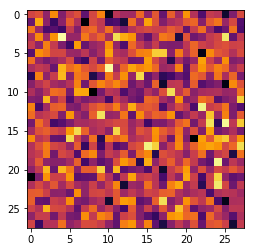

In [27]:
n_batch = 100
n_epochs = 25
N_train = X_train.shape[0]

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
for e in range(n_epochs):
    for i in range(N_train // n_batch):
        batch_X, batch_Y = X_train[i * n_batch:i * n_batch + n_batch], \
            Y_train[i * n_batch:i * n_batch + n_batch]
        sess.run(train_step, feed_dict={X: batch_X, Y_: batch_Y})
    
    Y_pred = sess.run(Y, feed_dict={X: X_test, Y_: Y_test})
    print("Epoch: {}\tTest Accuracy: {}".format(e + 1, roc_auc_score(Y_test, Y_pred)))

plt.imshow(W.eval().reshape((28, 28)), interpolation="nearest", cmap="inferno")